This notebook is a continuation of the `fim_matching_IEEE14.ipynb`.
Here, we will only look at some area in the network.
Following the paper by Transtrum et al. (https://ieeexplore.ieee.org/abstract/document/8586586), we will consider the area B, consisting of buses 6, 7, 8, 9, 10, 11, 12, 13, and 14.

In [1]:
from pathlib import Path
import json

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from information_matching.convex_optimization import ConvexOpt
from information_matching.utils import tol, eps

%matplotlib inline
plt.style.use("default")

In [2]:
# Set directories
case = 14  # 14-bus case

WORK_DIR = Path().absolute()
FIM_DIR = WORK_DIR / "FIMs"
DATA_DIR = WORK_DIR / "models" / "data"

# Setup

First, remember that we only want to make measurement of the buses in the area and we only care about the observability of these buses.

In [3]:
# Load the area data, which contains information about which buses in the area
with open(DATA_DIR / "area_partition.json", "r") as f:
    area_dict = json.load(f)

area = "AreaB"
buses_area = area_dict[area]

In [4]:
# Model information
nparams = 2 * case

In [5]:
# Configurations
nconfigs = len(buses_area)
configs = buses_area
config_ids = np.array([f"bus{ii}" for ii in configs])
config_ids

array(['bus6', 'bus7', 'bus8', 'bus9', 'bus10', 'bus11', 'bus12', 'bus13',
       'bus14'], dtype='<U5')

In [6]:
# Load configuration FIMs
# Note that each candidate bus still measure the voltage phasor for all connected
# buses, even outside the area of interest.
fim_configs_tensor = np.empty((nconfigs, nparams, nparams))
for ii, bus in enumerate(configs):
    J = np.load(FIM_DIR / f"jacobian_bus{bus}.npy")
    I = J.T @ J
    fim_configs_tensor[ii] = I
# Scaling factor to help the convex optimization
norm = max(np.linalg.norm(fim_configs_tensor, axis=(1, 2)))
fim_configs_tensor[0].shape

(28, 28)

In [7]:
# Target FIM
# Index of the parameters for observation within the area
idx_buses = np.array(buses_area) - 1  # buses zero-based index
idx_params = np.sort(np.append(2 * idx_buses, 2 * idx_buses + 1))

lambda_tol = 1e-5  # Eigenvalue cutoff
fim_target = np.diag(np.zeros(nparams))
fim_target[idx_params, idx_params] = np.ones_like(idx_params) * lambda_tol
print("Eigenvalue lower bound:", lambda_tol)

Eigenvalue lower bound: 1e-05


# Convex optimization

Additional note:

We will perform the optimization iteratively.
In each iteration, we scale the weights being optimize by the optimal weights from the previous iteration.
By doing so, the objective function in the convex optimization better mimics $\ell_0$-norm to enforce sparsity.

In [8]:
# Construct the input FIMs
# FIM target is fine, because we only apply scale 1.0
# FIM configs
fim_configs = {}
for ii, identifier in enumerate(config_ids):
    fim_configs.update(
        {identifier: {"fim": fim_configs_tensor[ii], "fim_scale": 1 / norm}}
    )

In [9]:
# Before running the optimization, we have performed similar calculation, but with
# Mixed-integer semi-definite programming (MISDP) problem in Matlab. That result can
# be used as an initial guess to speed up the calculation here. As suppose to the
# MISDP version of the method, the regular SDP version can find continuous values.
opt_buses_misdp = np.loadtxt(
    WORK_DIR / "data" / "misdp_optimal_buses_areaB.txt", delimiter=",", dtype=int
)
try:
    len(opt_buses_misdp)
except TypeError:  # There is only 1 bus, not a list
    opt_buses_misdp = [opt_buses_misdp]
opt_buses_misdp_idx = [configs.index(val) for val in opt_buses_misdp]

Tolerance: 1.8189894035458565e-12
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.0000000853355681e-08


/home/byu.local/yonatank/.local/lib/python3.7/site-packages/cvxpy/problems/problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.313862015001181e-08
cannot cholesky decomposition :: line 486 in sdpa_linear.cpp
Could you try with smaller gammaStar? :: line 487 in sdpa_linear.cpp
cannot cholesky decomposition :: line 486 in sdpa_linear.cpp
Could you try with smaller gammaStar? :: line 487 in sdpa_linear.cpp
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.3224788553966344e-08
cannot cholesky decomposition :: line 486 in sdpa_linear.cpp
Could you try with smaller gammaStar? :: line 487 in sdpa_linear.cpp
cannot cholesky decomposition :: line 486 in sdpa_linear.cpp
Could you try with smaller gammaStar? :: line 487 in sdpa_linear.cpp
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.322510969432518e-08

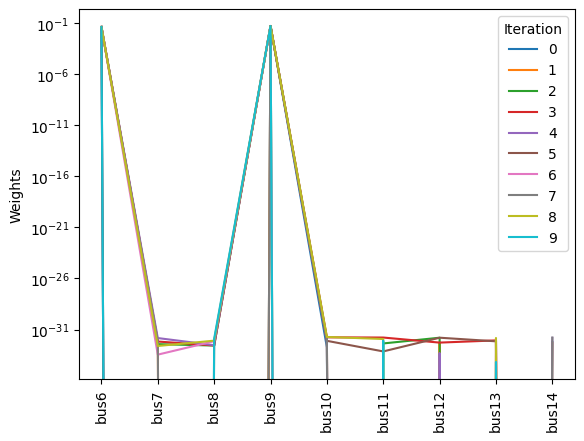

In [10]:
# Convex optimization
# Settings
cvx_tol = eps ** 0.75
solver = dict(verbose=False, solver=cp.SDPA, epsilonStar=cvx_tol)
print("Tolerance:", cvx_tol)

plt.figure()
# Use the MISDP result as an initial guess
wopt = np.zeros(nconfigs)
wopt[opt_buses_misdp_idx] = 1.0
for ii in range(10):
    # Update the weight scales
    for jj, identifier in enumerate(config_ids):
        # Add weight scale information,aAdd some small number for numerical stability
        fim_configs[identifier].update({"weight_scale": 1 / (wopt[jj] + 1e-15)})
    cvxopt = ConvexOpt(fim_target, fim_configs, l1norm_obj=True)

    try:
        # Solve
        cvxopt.solve(**solver)
        result = cvxopt.result.copy()
        wopt = result["wm"]
        dual = result["dual_wm"]
        print("Violation:", cvxopt.constraints[1].violation())
    except Exception:
        cvxopt.result = result
        break

    plt.plot(wopt, label=ii)
    
print("Optimal value:", result["value"])

plt.yscale("log")
plt.xticks(range(nconfigs), config_ids, rotation=90)
plt.ylabel("Weights")
plt.legend(title="Iteration", bbox_to_anchor=(1, 1))
plt.show()

## Post-processing

In [11]:
# Get the optimal buses
# Index to the optimal buse`s
idx_wopt = cvxopt._get_idx_nonzero_wm(np.sqrt(cvx_tol), np.sqrt(cvx_tol))
print("Optimal buses:")
_ = [print(f'{config_ids[ii]} \t {wopt[ii]}') for ii in idx_wopt]

Optimal buses:
bus6 	 0.045559940914570704
bus9 	 0.05672294960212262


Eigenvalues:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.95813801e-03 9.28059402e-03
 9.36832036e-03 9.43372926e-03 9.69991786e-02 1.08081435e-01
 6.28457033e-01 6.36621233e-01 6.87963147e-01 6.92124404e-01
 8.73024521e-01 9.38098370e-01 1.40735364e+00 1.55153220e+00
 1.57750071e+00 1.73888613e+00 5.94646800e+00 6.73025470e+00
 1.31113347e+01 1.45756262e+01 6.28483772e+01 7.06571503e+01]


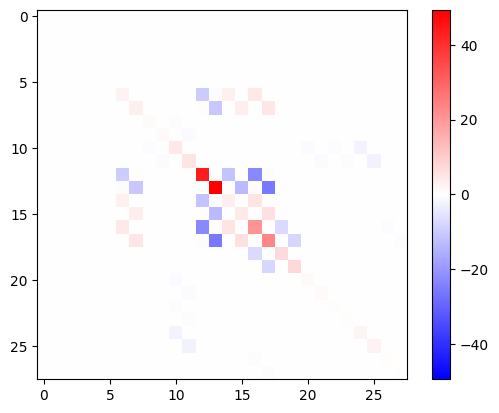

In [12]:
# Plot the optimal configuration FIM
weighted_fims_configs = fim_configs_tensor * wopt.reshape((-1, 1, 1))
I = np.sum(weighted_fims_configs[idx_wopt], axis=0)
print("Eigenvalues:")
print(np.linalg.eigvalsh(I))

plt.figure()
cbound = np.max([abs(np.min(I)), abs(np.max(I))])
plt.imshow(I, vmin=-cbound, vmax=cbound, cmap="bwr")
plt.colorbar()
plt.show()